In [1]:
# Автоматическая перезагрузка модулей при изменении
# Позволяет обновлять код в helper.py, plots.py, nlp.py без перезапуска ядра
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from functions import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sentence_transformers import SentenceTransformer
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorWithPadding, get_linear_schedule_with_warmup
from sklearn.dummy import DummyClassifier 
from sklearn.tree import DecisionTreeClassifier  # дерево решений
from sklearn.ensemble import RandomForestClassifier  # случайный лес
from lightgbm import LGBMClassifier  # градиентный бустинг
from helper import *
from plots import *
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer







[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dima2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dima2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\dima2\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv(r"c:\Users\dima2\Downloads\Telegram Desktop\train_science.csv")
print(df.head())

       Id                                            Comment      Topic
0   0x840  A few things. You might have negative- frequen...    Biology
1   0xbf0  Is it so hard to believe that there exist part...    Physics
2  0x1dfc                                     There are bees    Biology
3   0xc7e  I'm a medication technician. And that's alot o...    Biology
4   0xbba                     Cesium is such a pretty metal.  Chemistry


In [4]:
SEED=42

In [6]:
df.info()#Смотрим информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
dtypes: object(3)
memory usage: 203.9+ KB


In [7]:
df['Topic'].value_counts()#Смотрим распределение топиков

Topic
Biology      3591
Chemistry    2920
Physics      2184
Name: count, dtype: int64

In [8]:
df['Topic'].isnull().sum()

np.int64(0)

In [9]:
df['Comment'].str.len().describe()#Смотрим на длину наших текстов

count    8695.000000
mean      169.286832
std       294.992807
min         1.000000
25%        36.000000
50%        78.000000
75%       174.000000
max      7298.000000
Name: Comment, dtype: float64

In [10]:
df.duplicated(subset=['Comment']).sum()# проверяем дубликаты

np.int64(745)

In [11]:
# Сгруппируем по тексту и посмотрим, сколько разных меток у каждого
duplicates_with_labels = (
    df.groupby('Comment')['Topic']
      .nunique()
      .reset_index()
      .rename(columns={'Topic': 'unique_labels_count'})
)

# Оставим только те тексты, где меток больше 1 (то есть противоречия)
conflicted = duplicates_with_labels[duplicates_with_labels['unique_labels_count'] > 1]

print(f"Количество конфликтных дубликатов: {len(conflicted)}")


Количество конфликтных дубликатов: 20


In [12]:
conflicted_examples = df[df['Comment'].isin(conflicted['Comment'])] \
    .sort_values('Comment')

conflicted_examples.head(20)
#Смотрим что за текста которые являются одинаковыми но при этом имеют разные метки


,Id,Comment,Topic
633,0x1c42,No,Chemistry
3454,0xe1b,No,Chemistry
1944,0x2731,No,Physics
5373,0xbd4,No,Chemistry
6205,0x6a5,No.,Chemistry
4345,0x14ab,No.,Physics
5103,0x79c,No.,Chemistry
3408,0x1f1b,Ok thank you,Physics
8050,0x1c18,Ok thank you,Chemistry
6163,0x2531,Ok thank you,Physics


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       8695 non-null   object
 1   Comment  8695 non-null   object
 2   Topic    8695 non-null   object
dtypes: object(3)
memory usage: 203.9+ KB


In [14]:
df['n_chars'] = df['Comment'].str.len()
df['n_words'] = df['Comment'].str.split().map(len)

display(df.groupby('Topic')[['n_chars','n_words']].describe().T)
#Смотрим распределение количества слов и количества букв в наших текстах 


Topic              Biology    Chemistry      Physics
n_chars count  3591.000000  2920.000000  2184.000000
        mean    161.679476   157.393836   197.695971
        std     295.262206   243.605110   350.365334
        min       4.000000     1.000000     1.000000
        25%      35.000000    37.000000    36.750000
        50%      71.000000    79.000000    93.500000
        75%     150.000000   167.000000   214.000000
        max    5249.000000  2765.000000  7298.000000
n_words count  3591.000000  2920.000000  2184.000000
        mean     27.638819    27.082192    32.998626
        std      48.840005    41.428460    58.975196
        min       1.000000     1.000000     1.000000
        25%       6.000000     6.000000     6.000000
        50%      13.000000    14.000000    16.000000
        75%      25.000000    29.000000    36.000000
        max     837.000000   446.000000  1274.000000

In [15]:
# Фильтруем строки, где количество слов >= 10
new_df = df[df['Comment'].str.split().str.len() >= 10]

# Сбрасываем индексы, чтобы было аккуратно
new_df = new_df.reset_index(drop=True)


In [16]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5435 entries, 0 to 5434
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       5435 non-null   object
 1   Comment  5435 non-null   object
 2   Topic    5435 non-null   object
 3   n_chars  5435 non-null   int64 
 4   n_words  5435 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 212.4+ KB


In [17]:
new_df.duplicated(subset=['Comment']).sum()

np.int64(307)

In [18]:
# Сгруппируем по тексту и посмотрим, сколько разных меток у каждого
duplicates_with_labels = (
    new_df.groupby('Comment')['Topic']
      .nunique()
      .reset_index()
      .rename(columns={'Topic': 'unique_labels_count'})
)

# Оставим только те тексты, где меток больше 1 (то есть противоречия)
conflicted = duplicates_with_labels[duplicates_with_labels['unique_labels_count'] > 1]

print(f"Количество конфликтных дубликатов: {len(conflicted)}")


Количество конфликтных дубликатов: 0


In [19]:
new_df.describe()

,n_chars,n_words
count,5435.000000,5435.000000
mean,252.766697,43.125299
std,346.952660,57.906064
min,38.000000,10.000000
25%,85.000000,15.000000
50%,132.000000,23.000000
75%,273.000000,47.000000
max,7298.000000,1274.000000


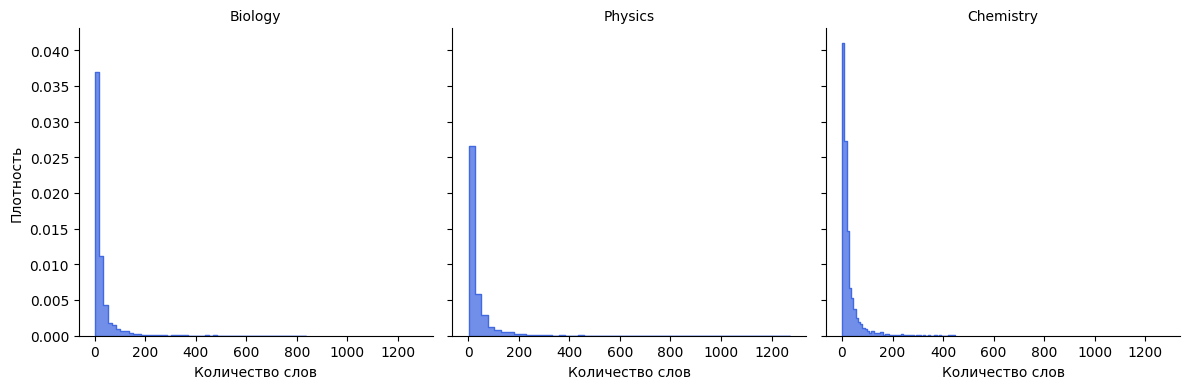

In [20]:
#Смотрим на распределение количества слов в текстах по группам
g = sns.FacetGrid(df, col="Topic", col_wrap=3, sharex=True, sharey=True, height=4)
g.map(sns.histplot, "n_words", bins=50, element="step", stat="density", color="royalblue")
g.set_titles("{col_name}")
g.set_axis_labels("Количество слов", "Плотность")
plt.show()
#Видим что большинство текстов в каждой группе имеют меньше 100 слов


In [21]:
#Посмотрим на примеры текстов из каждой группы
for lab in df['Topic'].unique():
    print('===', lab, '===\n')
    print(new_df[new_df['Topic']==lab]['Comment'].sample(5, random_state=42).tolist())
    print('\n')


=== Biology ===

['I call them wheel bugs but they are definitely a type of assign bug like previously mentioned', 'Ok but can I drink it anyway? If it’s served cold on a hoy day I probably won’t notice… and I’ll blame the next day diarrhea on the poor choices of snacks I select after the third one…', 'I moved him so he wouldn\'t get squished...he looked at me like he was upset I would do such a thing but, his horn was never close enough to do any "Damage" to me.\\n\\nThanks for all the info!', 'If distilled water is present on both sides then “no” net osmosis occurs. If the solution is different (one side distilled/RO, another including solubles in water or non RO Water) then Osmosis occurs leaving one side with solubles (minerals, etc…) and other side with RO water. Therefore when solubles are left behind there is less water content (on the side that has not yet been filtered). In lamest terms non filtered side has less water content since it’s being cluttered with solubles (minerals

In [22]:
#Рассмотри самые частовстречающие слова в каждой группе
stop_ru = set(stopwords.words('english'))

def top_n_words(texts, n=40):
    words = []
    for t in texts:
        toks = re.findall(r'\w+', str(t).lower())
        words.extend([w for w in toks if w not in stop_ru])
    return Counter(words).most_common(n)

for lab in new_df['Topic'].unique():
    print('---', lab, '---')
    print(top_n_words(new_df[new_df['Topic']==lab]['Comment'], n=30))


--- Biology ---
[('n', 1161), ('like', 378), ('would', 359), ('one', 331), ('get', 241), ('people', 238), ('think', 211), ('know', 208), ('also', 189), ('could', 177), ('even', 169), ('body', 156), ('much', 154), ('alan', 144), ('really', 141), ('water', 141), ('need', 138), ('well', 132), ('good', 129), ('cells', 126), ('time', 123), ('see', 122), ('life', 121), ('https', 120), ('different', 116), ('way', 116), ('something', 114), ('things', 111), ('species', 108), ('first', 108)]
--- Physics ---
[('n', 1085), ('would', 367), ('time', 244), ('like', 239), ('energy', 228), ('physics', 218), ('think', 199), ('one', 189), ('light', 158), ('also', 153), ('could', 140), ('get', 138), ('see', 138), ('even', 131), ('way', 130), ('force', 130), ('know', 127), ('matter', 125), ('make', 118), ('https', 110), ('data', 107), ('1', 107), ('air', 107), ('quantum', 106), ('really', 101), ('much', 98), ('people', 97), ('good', 97), ('mass', 97), ('speed', 90)]
--- Chemistry ---
[('n', 1014), ('like',

In [23]:
new_df['Comment'] = new_df['Comment'].astype(str).apply(clean_text)#Очистим текст от ненужным символов и приведём к нижнему регистру

In [24]:
new_df.head(10)

,Id,Comment,Topic,n_chars,n_words
0,0x840,a few things you might have negative frequency...,Biology,1519,254
1,0xbf0,is it so hard to believe that there exist part...,Physics,198,37
2,0xc7e,i m a medication technician and that s alot of...,Biology,187,33
3,0x531,i mean it has some butter but besides that it ...,Chemistry,94,18
4,0x2148,well that s just the thing you can t really in...,Biology,136,21
5,0xc19,is h s what produced when the egg protein is b...,Chemistry,289,52
6,0x2651,and the mrna would have to have a specific pro...,Biology,208,42
7,0xd2,he s probably just really torn up about the dr...,Biology,56,10
8,0x1aab,not free elections but it s what is called a l...,Chemistry,687,80
9,0x27de,this post was brought to you by vinegar it cle...,Biology,57,11


In [25]:
#Разделим данные на треин валидацию и тест
X = new_df['Comment']
y = new_df['Topic']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=SEED
)

print(len(X_train), len(X_val), len(X_test))

3804 815 816
